## Dependências

In [1]:
import os
import evaluate
import torch
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datasets import load_dataset, DatasetDict
from transformers import GraphormerForGraphClassification, TrainingArguments, Trainer
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

d:\Visual Code\Graphormer\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Variáveis

In [2]:
load_dotenv()

token = os.getenv("TOKEN")

## Dataset

In [3]:
dataset = load_dataset("graphs-datasets/MUTAG", cache_dir="../datasets")
dataset = dataset.shuffle(seed=0)

In [4]:
dataset['train'] = dataset['train'].remove_columns(['edge_attr'])
dataset = dataset['train'].train_test_split(test_size=0.2)
test_valid = dataset['test'].train_test_split(test_size=0.5)

dataset = DatasetDict({
    'train': dataset['train'],
    'test': test_valid['train'],
    'validation': test_valid['test']})

dataset["train"].features

{'edge_index': List(List(Value('int64'))),
 'node_feat': List(List(Value('float64'))),
 'y': List(Value('int64')),
 'num_nodes': Value('int64')}

## Métricas

In [5]:
metric = evaluate.load("accuracy")

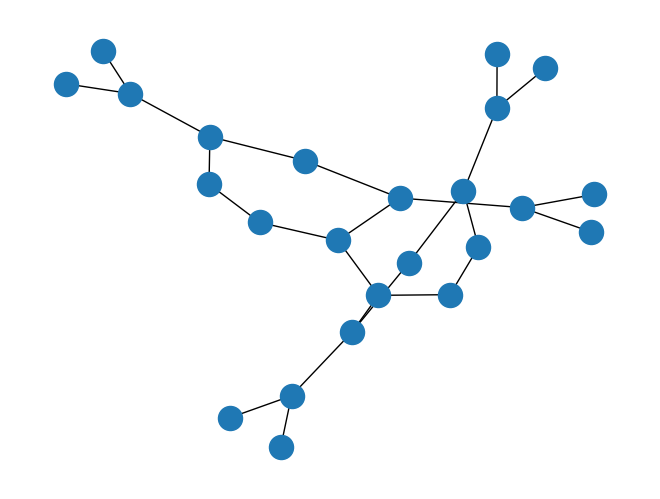

In [6]:
graph = dataset["train"][0]

edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

nx.draw(G)

In [7]:
"Label:" + str(graph['y'])

'Label:[1]'

## Processamento de Dados

In [8]:
dataset_processed = dataset.map(preprocess_item, batched=False)
train_ds = dataset_processed['train']
val_ds = dataset_processed['validation']

Map: 100%|██████████| 19/19 [00:00<00:00, 292.30 examples/s]


In [9]:
train_ds[0].keys()

dict_keys(['edge_index', 'node_feat', 'y', 'num_nodes', 'input_nodes', 'attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'out_degree', 'input_edges', 'labels'])

## Modelo

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [11]:
model = GraphormerForGraphClassification.from_pretrained(
    "clefourrier/pcqm4mv2_graphormer_base",
    token=token,
    num_classes=2,
    ignore_mismatched_sizes=True
).to(device)

d:\Visual Code\Graphormer\venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GraphormerForGraphClassification were not initialized from the model checkpoint at clefourrier/pcqm4mv2_graphormer_base and are newly initialized because the shapes did not match:
- classifier.classifier.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Argumentos

In [15]:
training_args = TrainingArguments(
    output_dir="../results",
    logging_dir="graph-classification",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    auto_find_batch_size=False,
    gradient_accumulation_steps=10,
    dataloader_num_workers=4, 
    num_train_epochs=20,
    evaluation_strategy="epoch",
    logging_strategy="epoch"
)

## Treino

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=GraphormerDataCollator()
)

In [17]:
train_results = trainer.train()

  0%|          | 0/60 [00:00<?, ?it/s]d:\Visual Code\Graphormer\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Could not estimate the number of tokens of the input, floating-point operations will not be computed
  5%|▌         | 3/60 [00:10<02:22,  2.51s/it]

{'loss': 0.8275, 'grad_norm': 5.508421421051025, 'learning_rate': 4.75e-05, 'epoch': 0.79}


                                              
  5%|▌         | 3/60 [00:14<02:22,  2.51s/it]

{'eval_loss': 0.5532358288764954, 'eval_runtime': 3.886, 'eval_samples_per_second': 4.889, 'eval_steps_per_second': 1.287, 'epoch': 0.79}


 12%|█▏        | 7/60 [00:24<02:25,  2.75s/it]

{'loss': 0.4623, 'grad_norm': 3.851961851119995, 'learning_rate': 4.4166666666666665e-05, 'epoch': 1.84}


                                              
 12%|█▏        | 7/60 [00:28<02:25,  2.75s/it]

{'eval_loss': 0.45702749490737915, 'eval_runtime': 3.8846, 'eval_samples_per_second': 4.891, 'eval_steps_per_second': 1.287, 'epoch': 1.84}


 18%|█▊        | 11/60 [00:39<02:17,  2.80s/it]

{'loss': 0.3815, 'grad_norm': 5.5877299308776855, 'learning_rate': 4.0833333333333334e-05, 'epoch': 2.89}


                                               
 18%|█▊        | 11/60 [00:43<02:17,  2.80s/it]

{'eval_loss': 0.4129144847393036, 'eval_runtime': 3.8223, 'eval_samples_per_second': 4.971, 'eval_steps_per_second': 1.308, 'epoch': 2.89}


 25%|██▌       | 15/60 [00:53<02:06,  2.80s/it]

{'loss': 0.3296, 'grad_norm': 6.040299415588379, 'learning_rate': 3.7500000000000003e-05, 'epoch': 3.95}


                                               
 25%|██▌       | 15/60 [00:57<02:06,  2.80s/it]

{'eval_loss': 0.4666951298713684, 'eval_runtime': 3.8357, 'eval_samples_per_second': 4.953, 'eval_steps_per_second': 1.304, 'epoch': 3.95}


 32%|███▏      | 19/60 [01:08<02:01,  2.97s/it]

{'loss': 0.3215, 'grad_norm': 16.367326736450195, 'learning_rate': 3.4166666666666666e-05, 'epoch': 5.0}


                                               
 32%|███▏      | 19/60 [01:11<02:01,  2.97s/it]

{'eval_loss': 0.3913438320159912, 'eval_runtime': 3.8457, 'eval_samples_per_second': 4.941, 'eval_steps_per_second': 1.3, 'epoch': 5.0}


 37%|███▋      | 22/60 [01:22<02:01,  3.21s/it]

{'loss': 0.439, 'grad_norm': 2.977104663848877, 'learning_rate': 3.1666666666666666e-05, 'epoch': 5.79}


                                               
 37%|███▋      | 22/60 [01:26<02:01,  3.21s/it]

{'eval_loss': 0.39899131655693054, 'eval_runtime': 3.8723, 'eval_samples_per_second': 4.907, 'eval_steps_per_second': 1.291, 'epoch': 5.79}


 43%|████▎     | 26/60 [01:36<01:38,  2.91s/it]

{'loss': 0.2902, 'grad_norm': 6.610710620880127, 'learning_rate': 2.8333333333333335e-05, 'epoch': 6.84}


                                               
 43%|████▎     | 26/60 [01:40<01:38,  2.91s/it]

{'eval_loss': 0.39384618401527405, 'eval_runtime': 3.8364, 'eval_samples_per_second': 4.953, 'eval_steps_per_second': 1.303, 'epoch': 6.84}


 50%|█████     | 30/60 [01:50<01:25,  2.85s/it]

{'loss': 0.2741, 'grad_norm': 4.740243911743164, 'learning_rate': 2.5e-05, 'epoch': 7.89}


                                               
 50%|█████     | 30/60 [01:54<01:25,  2.85s/it]

{'eval_loss': 0.39412057399749756, 'eval_runtime': 3.8302, 'eval_samples_per_second': 4.961, 'eval_steps_per_second': 1.305, 'epoch': 7.89}


 57%|█████▋    | 34/60 [02:05<01:13,  2.82s/it]

{'loss': 0.263, 'grad_norm': 2.523380994796753, 'learning_rate': 2.1666666666666667e-05, 'epoch': 8.95}


                                               
 57%|█████▋    | 34/60 [02:09<01:13,  2.82s/it]

{'eval_loss': 0.417032390832901, 'eval_runtime': 3.8502, 'eval_samples_per_second': 4.935, 'eval_steps_per_second': 1.299, 'epoch': 8.95}


 63%|██████▎   | 38/60 [02:19<01:06,  3.01s/it]

{'loss': 0.2395, 'grad_norm': 4.064130783081055, 'learning_rate': 1.8333333333333333e-05, 'epoch': 10.0}


                                               
 63%|██████▎   | 38/60 [02:23<01:06,  3.01s/it]

{'eval_loss': 0.4472508132457733, 'eval_runtime': 3.9078, 'eval_samples_per_second': 4.862, 'eval_steps_per_second': 1.279, 'epoch': 10.0}


 68%|██████▊   | 41/60 [02:34<01:01,  3.23s/it]

{'loss': 0.3469, 'grad_norm': 3.927779197692871, 'learning_rate': 1.5833333333333333e-05, 'epoch': 10.79}


                                               
 68%|██████▊   | 41/60 [02:38<01:01,  3.23s/it]

{'eval_loss': 0.4582662582397461, 'eval_runtime': 3.9703, 'eval_samples_per_second': 4.786, 'eval_steps_per_second': 1.259, 'epoch': 10.79}


 75%|███████▌  | 45/60 [02:48<00:44,  2.96s/it]

{'loss': 0.2531, 'grad_norm': 5.336689472198486, 'learning_rate': 1.25e-05, 'epoch': 11.84}


                                               
 75%|███████▌  | 45/60 [02:52<00:44,  2.96s/it]

{'eval_loss': 0.47249531745910645, 'eval_runtime': 3.8321, 'eval_samples_per_second': 4.958, 'eval_steps_per_second': 1.305, 'epoch': 11.84}


 82%|████████▏ | 49/60 [03:02<00:31,  2.85s/it]

{'loss': 0.2312, 'grad_norm': 3.5828440189361572, 'learning_rate': 9.166666666666666e-06, 'epoch': 12.89}


                                               
 82%|████████▏ | 49/60 [03:06<00:31,  2.85s/it]

{'eval_loss': 0.46359243988990784, 'eval_runtime': 3.8416, 'eval_samples_per_second': 4.946, 'eval_steps_per_second': 1.302, 'epoch': 12.89}


 88%|████████▊ | 53/60 [03:17<00:19,  2.82s/it]

{'loss': 0.254, 'grad_norm': 3.489457845687866, 'learning_rate': 5.833333333333334e-06, 'epoch': 13.95}


                                               
 88%|████████▊ | 53/60 [03:21<00:19,  2.82s/it]

{'eval_loss': 0.4519664943218231, 'eval_runtime': 3.8758, 'eval_samples_per_second': 4.902, 'eval_steps_per_second': 1.29, 'epoch': 13.95}


 95%|█████████▌| 57/60 [03:31<00:09,  3.01s/it]

{'loss': 0.2126, 'grad_norm': 4.356889247894287, 'learning_rate': 2.5e-06, 'epoch': 15.0}


                                               
 95%|█████████▌| 57/60 [03:35<00:09,  3.01s/it]

{'eval_loss': 0.4528810977935791, 'eval_runtime': 3.856, 'eval_samples_per_second': 4.927, 'eval_steps_per_second': 1.297, 'epoch': 15.0}


100%|██████████| 60/60 [03:44<00:00,  3.20s/it]

{'loss': 0.299, 'grad_norm': 16.189661026000977, 'learning_rate': 0.0, 'epoch': 15.79}


                                               
100%|██████████| 60/60 [03:48<00:00,  3.80s/it]

{'eval_loss': 0.45213523507118225, 'eval_runtime': 3.8271, 'eval_samples_per_second': 4.965, 'eval_steps_per_second': 1.306, 'epoch': 15.79}
{'train_runtime': 228.2778, 'train_samples_per_second': 13.142, 'train_steps_per_second': 0.263, 'train_loss': 0.3297990620136261, 'epoch': 15.79}


## Save

In [18]:
trainer.save_model(output_dir="../model")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =    15.7895
  total_flos               =        0GF
  train_loss               =     0.3298
  train_runtime            = 0:03:48.27
  train_samples_per_second =     13.142
  train_steps_per_second   =      0.263
